# Transparent Boundary Conditions for the dispersive part of the Serre Equation

* Definition and validation
* Objective : application to the DDM coupling Serre and NSWE


## Procedure
* Resolution of the dispersive part of the Serre equations
* Reference solution : solution computed in a larger domain
* BCs for the dispersion : TBCs --> study

In [1]:
%%writefile serreTBC.py

import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4


nan = float("nan")

Overwriting serreTBC.py


In [2]:
%%writefile serreTBC.py -a

import convolution as cvl

def imposeBCDispersive(M,rhs,BCs,h,hp1,u,hx,hu,dx,dt,nit,Y=[],uall=None,eta=0.):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * hp1 : information about h at this iteration (is already computed at the advection part)
        * dt
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ## first loop to compute TBC related parameters only once
    convol = False
    for i in range(BCs.shape[0]):
        [pos,typ,val] = BCs[i,:3]
        if typ == 'DTBC_Y':
            print " *  Computing convolutions"
            convol = True
            Ct = cvl.convolution_exact(nit+1, Y, uall)
            uu = (1./hp1)*(hu + dt*gr*h*hx) 
            break
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*hp1[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
            # rhs[pos] = val*h[pos]
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = dt*h[pos+1]*(alpha*dx - beta)
                M[pos,pos+1] = beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos+1]*(\
                                    alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                    beta*(u[pos+1] - u[pos] + dt*gr*(hx[pos+1]-hx[pos])) - dx*val)
            elif pos == 1 or pos == -1 :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
        elif typ == "TBC" or typ == "TBC2" or typ == "TBC3":  ##alpha*uxx + beta*ux + gamma*u = val 

            if typ == "TBC" :
                alpha = float(BCs[i,3])
                beta = float(BCs[i,4])
                gamma = float(BCs[i,5])
            elif typ == "TBC2" : ##with time derivative
                if pos == 0 :
                    alpha = u[0]*dt
                    beta = 1. - dt*(u[1]-u[0])/dx
                    gamma = 0.
                    val = (u[1]-u[0])/dx
                elif pos == -1 :
                    alpha = u[-1]*dt
                    beta = 1. - dt*(u[-1]-u[-2])/dx
                    gamma = 0.
                    val = (u[-1]-u[-2])/dx
            elif typ == "TBC3" : ##with time derivative : ut + u + ux + uxx= 0
                if pos == 0 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[0]
                elif pos == -1 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[-1]
            M[pos,:] = 0.
            if pos == 0:
                c0 = alpha/(dx*dx) - beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) + beta/dx
                c2 = alpha/(dx*dx)
                M[0,0] = -dt/h[0]*c0
                M[0,1] = -dt/h[1]*c1
                M[0,2] = -dt/h[2]*c2
                rhs[0] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == 1 :
                c0 = alpha/(dx*dx) - beta/dx
                c1 = -2.*alpha/(dx*dx) + beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[1,0] = -dt/h[0]*c0
                M[1,1] = -dt/h[1]*c1
                M[1,2] = -dt/h[2]*c2
                rhs[1] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == -1 :
                c0 = alpha/(dx*dx) + beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) - beta/dx
                c2 = alpha/(dx*dx)
                M[pos,pos] = -dt/h[pos]*c0
                M[pos,pos-1] = -dt/h[pos-1]*c1
                M[pos,pos-2] = -dt/h[pos-2]*c2
                rhs[pos] =val - (u[pos]+dt*gr*(hx[pos]+eta))*c0 - (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c1 - \
                                (u[pos-2]+dt*gr*(hx[pos-2]+eta))*c2
            elif pos == -2 :
                c0 = alpha/(dx*dx) + beta/dx
                c1 = -2.*alpha/(dx*dx) - beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[pos,pos+1] = -dt/h[pos+1]*c0
                M[pos,pos] = -dt/h[pos]*c1
                M[pos,pos-1] = -dt/h[pos-1]*c2
                rhs[pos] =val - (u[pos+1]+dt*gr*(hx[pos+1]+eta))*c0 - (u[pos]+dt*gr*(hx[pos]+eta))*c1 -\
                                (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c2
                            
        elif typ == "DTBC_Y":
            
            M[pos,:] = 0.
            
            if pos == 0:
                # Left TBC 1 ==> unknown = U[0]
                M[pos,0]   =  1.
                M[pos,1]   = -   Y[4,0]*hp1[0]/hp1[1]
                M[pos,2]   =     Y[6,0]*hp1[0]/hp1[2]
                val        = Ct[4,1] - Ct[6,2]
                rhs[pos]   = -(hp1[0]/dt)*( val - uu[0] + Y[4,0]*uu[1] - Y[6,0]*uu[2] )                
            elif pos == 1:
                # Left TBC 2 ==> unknown = U[1]
                M[pos,0]   =  1.
                M[pos,2]   = -   Y[5,0]*hp1[0]/hp1[2]
                M[pos,3]   =  2.*Y[8,0]*hp1[0]/hp1[3]
                M[pos,4]   = -   Y[7,0]*hp1[0]/hp1[4]
                val        = Ct[5,2] - 2*Ct[8,3] + Ct[7,4]
                rhs[pos]   = -(hp1[0]/dt)*( val - uu[0] + Y[5,0]*uu[2] - 2*Y[8,0]*uu[3] + Y[7,0]*uu[4] ) 
            elif pos == -1:
                ## Right TBC 1 ==> unknown = U[J]
                M[pos,-1]  =  1.
                M[pos,-2]  = -   Y[0,0]*hp1[-1]/hp1[-2]
                M[pos,-3]  =     Y[2,0]*hp1[-1]/hp1[-3]
                val        =  Ct[0,-2] - Ct[2,-3]
                rhs[pos]   = -(hp1[-1]/dt)*( val - uu[-1] + Y[0,0]*uu[-2] - Y[2,0]*uu[-3] )
            elif pos == -2:
                ## Right TBC 2 ==> unknown = U[J-1]
                M[pos,-1] =  1.
                M[pos,-2] = -2.*Y[0,0]*hp1[-1]/hp1[-2]
                M[pos,-3] =     Y[1,0]*hp1[-1]/hp1[-3]
                M[pos,-5] = -   Y[3,0]*hp1[-1]/hp1[-5]
                val       = 2*Ct[0,-2] - Ct[1,-3] + Ct[3,-5]
                rhs[pos]  = -(hp1[-1]/dt)*( val - uu[-1] + 2*Y[0,0]*uu[-2] - Y[1,0]*uu[-3] + Y[3,0]*uu[-5] )    
                
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC/DTBC_Y")
        
    if convol:
        return M,rhs,Ct
    else:
        return M,rhs,[]

Appending to serreTBC.py


In [3]:
%%writefile serreTBC.py -a

def imposeBCDispersiveLinear(M,rhs,BCs,h,u,hx,hu,dx,dt):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * dt
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ### verif number of TBCs
    #if BCs.shape[0] != 3 :
    #    sys.exit("Wrong number of BCs")
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = alpha - beta/dx
                M[pos,pos+1] = beta/dx
                rhs[pos] = val
            elif pos == 1 or pos == -1 :
                M[pos,pos] = alpha + beta/dx
                M[pos,pos-1] = -beta/dx
                rhs[pos] = val
        elif typ == "TBC" or typ == "TBC2" or typ == "TBC3":  ##alpha*uxx + beta*ux + gamma*u = val 

            if typ == "TBC" :
                alpha = float(BCs[i,3])
                beta = float(BCs[i,4])
                gamma = float(BCs[i,5])
            elif typ == "TBC2" : ##with time derivative
                if pos == 0 :
                    alpha = u[0]*dt
                    beta = 1. - dt*(u[1]-u[0])/dx
                    gamma = 0.
                    val = (u[1]-u[0])/dx
                elif pos == -1 :
                    alpha = u[-1]*dt
                    beta = 1. - dt*(u[-1]-u[-2])/dx
                    gamma = 0.
                    val = (u[-1]-u[-2])/dx
            elif typ == "TBC3" : ##with time derivative : ut + u + ux + uxx= 0
                if pos == 0 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[0]
                elif pos == -1 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[-1]
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = alpha/(dx*dx) - beta/dx + gamma
                M[0,1] = -2.*alpha/(dx*dx) + beta/dx
                M[0,2] = alpha/(dx*dx)
                rhs[0] = val
            elif pos == 1 :
                M[1,0] = alpha/(dx*dx) - beta/dx
                M[1,1] = -2.*alpha/(dx*dx) + beta/dx + gamma
                M[1,2] = alpha/(dx*dx)
                rhs[1] = val
            elif pos == -1 :
                M[-1,-1] = alpha/(dx*dx) + beta/dx + gamma
                M[-1,-2] = -2.*alpha/(dx*dx) - beta/dx
                M[-1,-3] = alpha/(dx*dx)
                rhs[-1] = val
            elif pos == -2 :
                M[-2,-1] = alpha/(dx*dx) + beta/dx 
                M[-2,-2] = -2.*alpha/(dx*dx) - beta/dx + gamma
                M[-2,-3] = alpha/(dx*dx)
                rhs[-2] = val
        
        else:
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC")
    return M,rhs

Appending to serreTBC.py


In [4]:
%%writefile serreTBC.py -a

def jacobi(M):
    """
    Return a Jacobi preconditioner for the matrix M.
    """
    
    prec = np.copy(np.diagonal(M))
    N = len(prec)
    prec[0]  = 1.
    prec[1]  = 1.
    prec[-2] = 1.
    prec[-1] = 1.
    for i in range(2,N-2):
        prec[i] = 1./prec[i]
        
    return np.diagflat(prec)

def EFDSolverFM4(h,u,dx,dt,order,BCs,nit=0,periodic=False,ng=2,side="left",href=None,uref=None,Y=[],uall=None,eta=0.,hp1=[]):
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    MODIFICATION : imposition of BCs
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81
    
    if hp1 == []:
        hp1 = np.copy(h)

    hu = h*u

    order=2
    ux = serre.get1d(u,dx,periodic,order=order)
    uxx = serre.get2d(u,dx,periodic,order=order)
    uux = u*ux
    uuxdx = serre.get1d(uux,dx,periodic,order=order)
    hx = serre.get1d(h,dx,periodic,order=order)
    hxx = serre.get2d(h,dx,periodic,order=order)
    h2x = serre.get1d(h*h,dx,periodic,order=order)
    hhx = h*hx
        
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx + eta*eta*h*u*ux + eta*eta*(hx+eta)*u*u
    rhs = gr*h*hx + h*Q + gr*h*eta      
     
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx) + eta*(hx+eta)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    np.set_printoptions(threshold=np.nan)
    
    M,rhs,Ct = imposeBCDispersive(M,rhs,BCs,h,hp1,u,hx,hu,dx,dt,nit,Y=Y,uall=uall,eta=eta)
    
    # prec = jacobi(M)
    # M    = np.dot(prec, M)
    # rhs  = np.dot(prec,rhs)
        
    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*(hx+eta)-z)
        
    if Y != []:
        u2 = hu2/hp1
        
        # print " *  Left"
        # print u2[0] - Y[4,0]*u2[1] - Ct[4,1] +   Y[6,0]*u2[2] +   Ct[6,2]
        # print u2[0] - Y[5,0]*u2[2] - Ct[5,2] + 2*Y[8,0]*u2[3] + 2*Ct[8,3] - Y[7,0]*u2[4] - Ct[7,4] 
        
        # print " *  Right"
        # print u2[-1] -   Y[0,0]*u2[-2] -   Ct[0,-2] + Y[2,0]*u2[-3] + Ct[2,-3] 
        # print u2[-1] - 2*Y[0,0]*u2[-2] - 2*Ct[0,-2] + Y[1,0]*u2[-3] + Ct[1,-3] - Y[3,0]*u2[-5] - Ct[3,-5]
    
    print " *  Residual"
    print np.linalg.norm(np.dot(M,z) - rhs)
    
    return hu2/hp1

Appending to serreTBC.py


In [5]:
%%writefile serreTBC.py -a

def linearEFDSolverFM(h,u,dx,dt,order,BCs,periodic=False,ng=2,side="left",href=None,uref=None,h0=None,u0=None,nit=None,Y=[]):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    MODIFICATION : imposition of BCs
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81

    hu = h*u

    order=2
    uxxx = serre.get3d(u,dx,periodic,order=order)
    uxx = serre.get2d(u,dx,periodic,order=order)
    hx = serre.get1d(h,dx,periodic,order=order)
    
    rhs = u-h0*h0/3.*uxx
    
    d0 = (1. + 5.*h0*h0/(6.*dx*dx))*np.ones_like(u)
    dp1 = h0*h0/(3*dx*dx)*(- 4./3. + 13./8.*dt*u0/dx)*np.ones_like(u)
    dp1 = dp1[0:-1]
    dm1 = h0*h0/(3*dx*dx)*(+ 4./3. - 13./8.*dt*u0/dx)*np.ones_like(u)
    dm1 = dm1[1:]
    dp2 = h0*h0/(3*dx*dx)*(- 1./12. -1.*dt*u0/dx)*np.ones_like(u)
    dp2 = dp2[0:-2]
    dm2 =  h0*h0/(3*dx*dx)*(- 1./12. + 1.*dt*u0/dx)*np.ones_like(u)
    dm2 = dm2[2:]
    dp3 = h0*h0/(3*dx*dx)*(+1./8.*dt*u0/dx)*np.ones_like(u)
    dp3 = dp3[0:-3]
    dm3 = h0*h0/(3*dx*dx)*(-1./8.*dt*u0/dx)*np.ones_like(u)
    dm3 = dm3[3:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2) + \
        np.diag(dp3,3) + np.diag(dm3,-3)

    M[0,:] = 0
    M[1,:] = 0
    # M[2,:] = 0
    M[-1,:] = 0
    M[-2,:] = 0
    # M[-3,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = 1. + h0*h0/(3.*dx*dx)* (2. - 5./2.*dt*u0/dx)
    M[0,1] = h0*h0/(3.*dx*dx)* (-5. + 9.*dt*u0/dx)
    M[0,2] = h0*h0/(3.*dx*dx)* (4. - 12.*dt*u0/dx)
    M[0,3] = h0*h0/(3.*dx*dx)* (-1. + 7.*dt*u0/dx)
    M[0,4] = h0*h0/(3.*dx*dx)* (-3./2.*dt*u0/dx)
    
    M[1,1] = 1. + h0*h0/(3.*dx*dx)* (2. - 5./2.*dt*u0/dx)
    M[1,2] = h0*h0/(3.*dx*dx)* (-5. + 9.*dt*u0/dx)
    M[1,3] = h0*h0/(3.*dx*dx)* (4. - 12.*dt*u0/dx)
    M[1,4] = h0*h0/(3.*dx*dx)* (-1. + 7.*dt*u0/dx)
    M[1,5] = h0*h0/(3.*dx*dx)* (-3./2.*dt*u0/dx)
    
    M[2,2] = 1. + h0*h0/(3.*dx*dx)* (2. - 5./2.*dt*u0/dx)
    M[2,3] = h0*h0/(3.*dx*dx)* (-5. + 9.*dt*u0/dx)
    M[2,4] = h0*h0/(3.*dx*dx)* (4. - 12.*dt*u0/dx)
    M[2,5] = h0*h0/(3.*dx*dx)* (-1. + 7.*dt*u0/dx)
    M[2,6] = h0*h0/(3.*dx*dx)* (-3./2.*dt*u0/dx)
    
    M[-1,-1] = 1. + h0*h0/(3.*dx*dx)* (2. + 5./2.*dt*u0/dx)
    M[-1,-2] = h0*h0/(3.*dx*dx)* (-5. - 9.*dt*u0/dx)
    M[-1,-3] = h0*h0/(3.*dx*dx)* (4. + 12.*dt*u0/dx)
    M[-1,-4] = h0*h0/(3.*dx*dx)* (-1. - 7.*dt*u0/dx)
    M[-1,-5] = h0*h0/(3.*dx*dx)* (+3./2.*dt*u0/dx)
      
    M[-2,-2] = 1. + h0*h0/(3.*dx*dx)* (2. + 5./2.*dt*u0/dx)
    M[-2,-3] = h0*h0/(3.*dx*dx)* (-5. - 9.*dt*u0/dx)
    M[-2,-4] = h0*h0/(3.*dx*dx)* (4. + 12.*dt*u0/dx)
    M[-2,-5] = h0*h0/(3.*dx*dx)* (-1. - 7.*dt*u0/dx)
    M[-2,-6] = h0*h0/(3.*dx*dx)* (+3./2.*dt*u0/dx)
    
    M[-3,-3] = 1. + h0*h0/(3.*dx*dx)* (2. + 5./2.*dt*u0/dx)
    M[-3,-4] = h0*h0/(3.*dx*dx)* (-5. - 9.*dt*u0/dx)
    M[-3,-5] = h0*h0/(3.*dx*dx)* (4. + 12.*dt*u0/dx)
    M[-3,-6] = h0*h0/(3.*dx*dx)* (-1. - 7.*dt*u0/dx)
    M[-3,-7] = h0*h0/(3.*dx*dx)* (+3./2.*dt*u0/dx)
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt, nit=nit, Y=Y)
    
    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*hx-z)
    
    return hu2/h

Appending to serreTBC.py


In [6]:
%%writefile serreTBC.py -a

def solveDispersiveSerre(u,href,t0,tmax,dt,dx,BCconfig,uref=None,debug=False,idxlims=None, Y=[]):
    
    t = t0
    it = 0 ## index of timestep
    grav = 9.8
    
    ## store solutions of all timesteps
    uall = u
    tall = np.ones(1)*t0
    
    while abs(t-tmax) > 10**(-12):
        
        print "------------------"
        print " *  t =", t+dt
            
        ## h(t) = referential solution
        h = href[:,it]
        hu = h*u

        FDorder = 4 
        
        if debug :
            # BCconfig[0,2] = uref[idxlims[0],it+1]
            BCconfig[1,2] = uref[idxlims[1],it+1]
            # BCconfig[2,2] = uref[idxlims[0]+1,it+1]
            BCconfig[3,2] = uref[idxlims[1]-1,it+1]
        
        u = EFDSolverFM4(h,u,dx,dt,FDorder,BCconfig, it, Y=Y, uall=uall, hp1=href[:,it+1])

        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        t = t+dt
        it = it+1
        
    return uall,tall

Appending to serreTBC.py


In [7]:
%%writefile serreTBC.py -a

def solveLinearDispersiveSerre(u,href,t0,tmax,dt,dx,BCconfig,uref=None,debug=False,idxlims=None,h0=None,u0=None, Y=[]):
    
    t = t0
    it = 0 ## index of timestep
    grav = 9.8
    
    ## store solutions of all timesteps
    uall = u
    tall = np.ones(1)*t0
    
    while t < tmax:
        
        ## h(t) = referential solution
        h = href[:,it]
        hu = h*u

        FDorder = 4 
        
        if debug :
            BCconfig[0,2] = uref[idxlims[0],it+1]
            BCconfig[1,2] = uref[idxlims[1],it+1]
            BCconfig[2,2] = uref[idxlims[0]+1,it+1]
            BCconfig[3,2] = uref[idxlims[1]-1,it+1]
            # BCconfig[4,2] = uref[idxlims[0]+2,it+1]
            # BCconfig[5,2] = uref[idxlims[1]-2,it+1]
        u = linearEFDSolverFM(h,u,dx,dt,FDorder,BCconfig,h0=h0,u0=u0, nit=it, Y=Y)

        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        
        t = t+dt
        it = it+1
        
    return uall,tall

Appending to serreTBC.py


In [8]:
%%writefile serreTBC.py -a

def computeErrorTBC(u,uref,idxlims,dx,dt):
    lim1 = idxlims[0]
    lim2 = idxlims[1]
    uwind = uref[lim1:lim2+1,:]
    errDom = np.linalg.norm(u-uwind)*np.sqrt(dx*dt)
    errInt1 = np.linalg.norm(u[0,:]-uwind[0,:])*np.sqrt(dt)
    errInt2 = np.linalg.norm(u[-1,:]-uwind[-1,:])*np.sqrt(dt)
    
    return errDom,errInt1,errInt2
    

Appending to serreTBC.py


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4
import sys
import serreTBC
import generalFunctions as gF

reload(serre)
reload(serreTBC)
%matplotlib inline

In [10]:
a0 = 0.3
a1 = 0.1 ##0.01
k = 0.99
g = 9.81
t0 = 0.
tmax = 4.5
dt = 0.05

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 3.*lam
xmin = -L
xmax = L
nx = 100
x,dx = serre.discretizeSpace(xmin,xmax,nx)
dx = np.diff(x)[0]

## reference domain
xminref = -2*L
xmaxref = 2*L
nxref = 2*nx

xref,dxref = serre.discretizeSpace(xminref,xmaxref,nxref)
dxref = np.diff(xref)[0]

tallaux = np.arange(t0,tmax+dt,dt)
hall = np.zeros((x.size,tallaux.size))
hallref = np.zeros((xref.size,tallaux.size))

In [11]:
t = t0
h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
href,uref = cnoidal.analyticalSolutionSolitary(xref,t,a0,a1)

## construct a solution for h
for j in range(tallaux.size):
    t = tallaux[j]
    hall[:,j],trash = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
    hall[:,j] = hall[:,j] + np.flipud(hall[:,j])
    hallref[:,j],trash = cnoidal.analyticalSolutionSolitary(xref,t,a0,a1)
    hallref[:,j] = hallref[:,j] + np.flipud(hallref[:,j])

idxint1 = np.argmin(np.absolute(xref-x[0]))
idxint2 = np.argmin(np.absolute(xref-x[-1]))

##solve referential solution
BCconfigRef = np.array([[0,"Dirichlet",0.,1.,0.],
                        [1,"Dirichlet",0.,1.,0.],
                        [-1,"Dirichlet",0.,1.,0.],
                        [-2,"Dirichlet",0.,1.,0.]], dtype=object) ### Dirichlet (solution far enough from the boundaries)
uallref,tallref = serreTBC.solveDispersiveSerre(uref,hallref,t0,tmax,dt,dx,BCconfigRef)

------------------
 *  t = 0.05
 *  Residual
5.787734328312727e-16
------------------
 *  t = 0.1
 *  Residual
1.1047478321561547e-15
------------------
 *  t = 0.15
 *  Residual
1.3561310367027342e-15
------------------
 *  t = 0.2
 *  Residual
1.135583050757511e-15
------------------
 *  t = 0.25
 *  Residual
1.8591146231310784e-15
------------------
 *  t = 0.3
 *  Residual
1.0538426604812114e-15
------------------
 *  t = 0.35
 *  Residual
8.67705599669224e-16
------------------
 *  t = 0.4
 *  Residual
8.803331058487852e-16
------------------
 *  t = 0.45
 *  Residual
9.597641252377148e-16
------------------
 *  t = 0.5
 *  Residual
1.038695909995346e-15
------------------
 *  t = 0.55
 *  Residual
9.177008999692462e-16
------------------
 *  t = 0.6
 *  Residual
9.057195793562524e-16
------------------
 *  t = 0.65
 *  Residual
1.1936209807961187e-15
------------------
 *  t = 0.7
 *  Residual
7.683508923530829e-16
------------------
 *  t = 0.75
 *  Residual
9.381352545265598e-1

In [12]:
# Y coefficients for the DTBC of the linearized Serre equations

import Zt_tools as Z
print h0
Nf = 10**3
ps = Z.Parameters(h0, dx, nx, xmin, xmax, dt, Nf)
# we assume we don't go too far from the initial value of u so we keep the same mean for all the process
Y = Z.compute_Y3(ps)
# ub = np.mean(u)
# Y = Z.compute_Y2(ps, ub)
# Y = Z.compute_Y(ps)
# Z.plot_Y(Y, Nf, log_scale = True, export = False, save = False)
# K = Z.compute_K(dx, 1)

0.32749170021928925
*** Starting computations of Ys
*** Computation of Ys (in Fourier space) --> done

*** Applying iFFT on Ys
 *  max(Y1) = 0.324130448291
 *  max(Y2) = 0.324130448291
*** iFFT --> done



## Testing TBC

In [13]:
reload(serreTBC)
## Debugging (Dirichlet condition using the values on the interface
cond_l = "DTBC_Y"
cond_r = "DTBC_Y"
BCconfig = np.array([[0,cond_l,0.,1.,0.,1.],
                     [-1,cond_r,0.,1.,0.,1.],
                     [1,cond_l,0.,1.,0.,1.],
                     [-2,cond_r,0.,1.,0.,1.]], dtype=object) ## Dirichlet and Neumann
uall,tall = serreTBC.solveDispersiveSerre(u,hall,t0,tmax,dt,dx,BCconfig,
                                 uref=uallref,debug=False,idxlims=np.array([idxint1,idxint2]),Y=Y)

errDom, errInt1, errInt2 = serreTBC.computeErrorTBC(uall,uallref,np.array([idxint1,idxint2]),dx,dt)

print(errDom, errInt1, errInt2)

## extend solution of small domain to the size of big domain (only for plotting)
uall1 = np.zeros_like(uallref)
uall1[idxint1:idxint2+1,:] = uall

hall1 = np.zeros_like(hallref)
hall1[idxint1:idxint2+1,:] = hall

umin = np.amin(uallref)
umax = np.amax(uallref)
hmin = np.amin(hallref)
hmax = np.amax(hallref)

------------------
 *  t = 0.05
 *  Computing convolutions
 *  Residual
1.4604519199217802e-15
------------------
 *  t = 0.1
 *  Computing convolutions
 *  Residual
1.1949979258839682e-15
------------------
 *  t = 0.15
 *  Computing convolutions
 *  Residual
7.656087672207163e-16
------------------
 *  t = 0.2
 *  Computing convolutions
 *  Residual
1.1153970402914349e-15
------------------
 *  t = 0.25
 *  Computing convolutions
 *  Residual
1.2670889915952637e-15
------------------
 *  t = 0.3
 *  Computing convolutions
 *  Residual
1.3634767615207698e-15
------------------
 *  t = 0.35
 *  Computing convolutions
 *  Residual
1.4001825743733486e-15
------------------
 *  t = 0.4
 *  Computing convolutions
 *  Residual
1.3652218194214506e-15
------------------
 *  t = 0.45
 *  Computing convolutions
 *  Residual
9.676484112917553e-16
------------------
 *  t = 0.5
 *  Computing convolutions
 *  Residual
1.1147639912969337e-15
------------------
 *  t = 0.55
 *  Computing convolution

*** Plotting animation ...



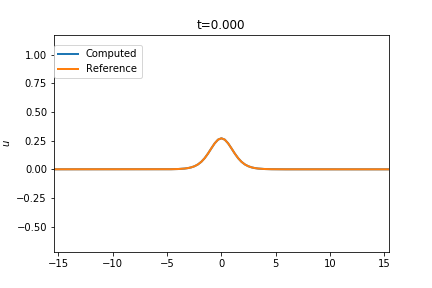
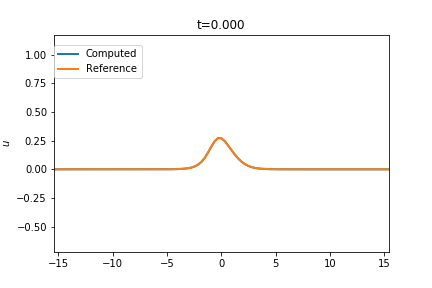
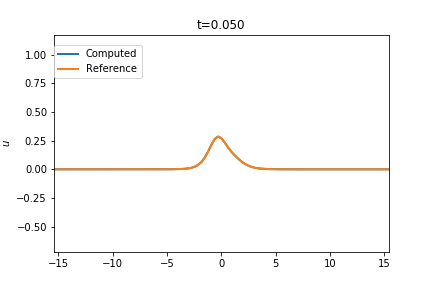
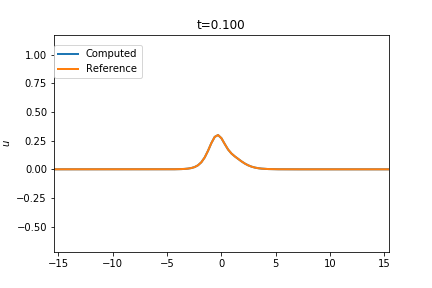
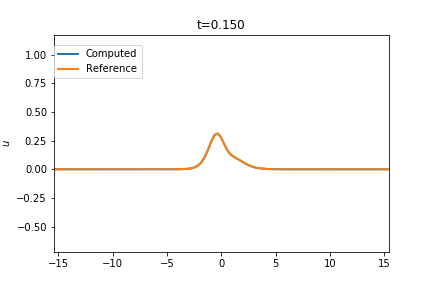
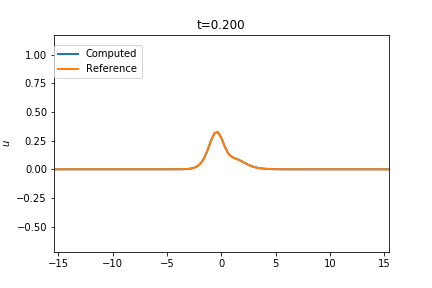
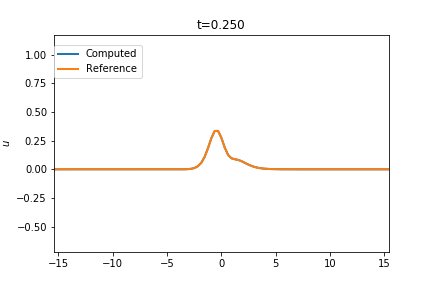
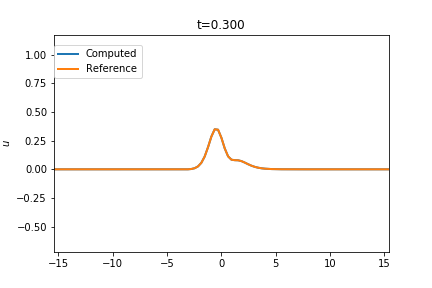
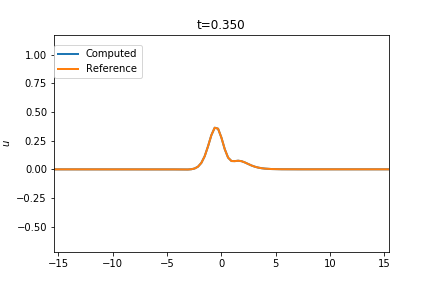
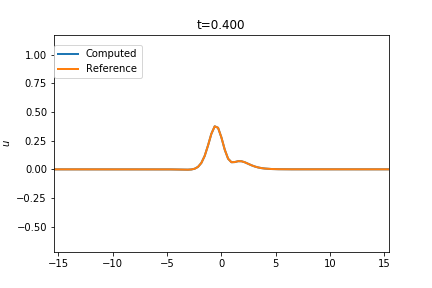
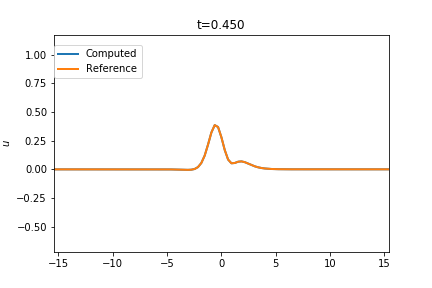
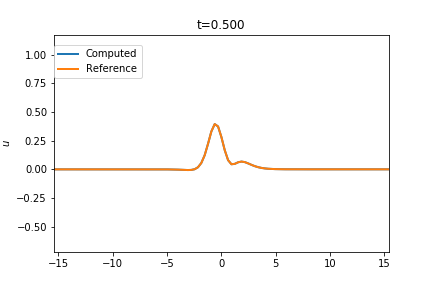
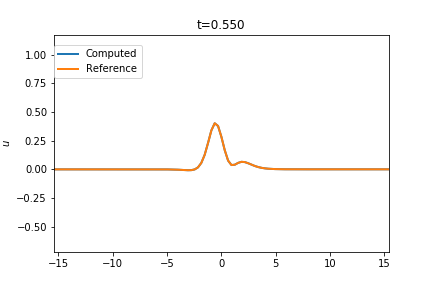
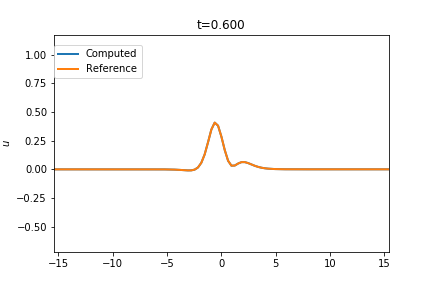
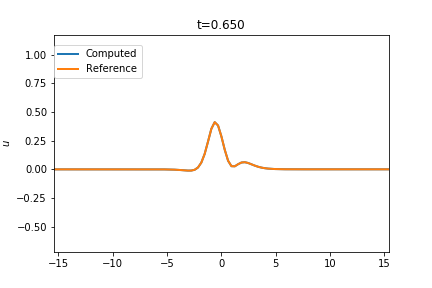
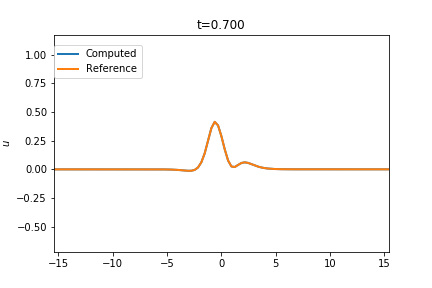
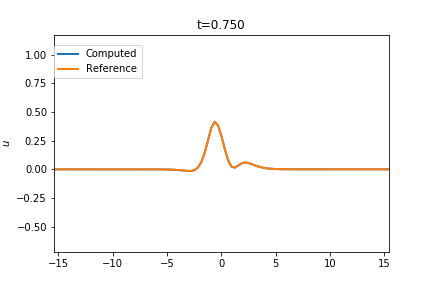
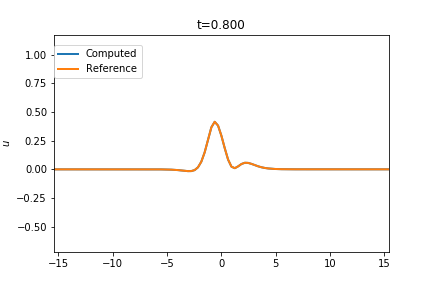
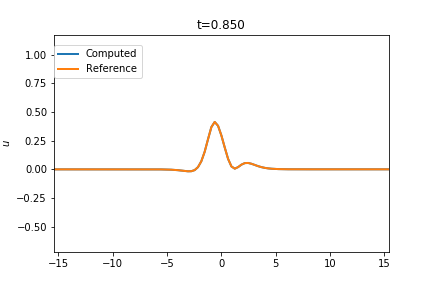
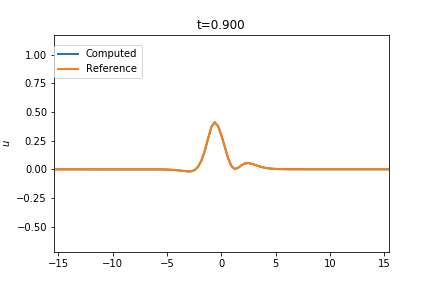
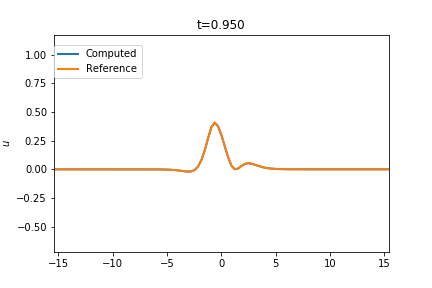
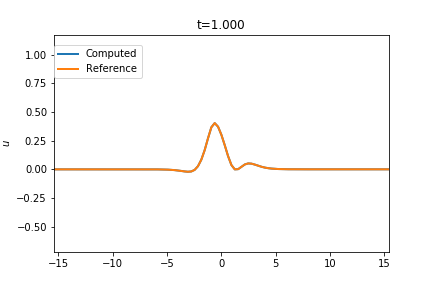
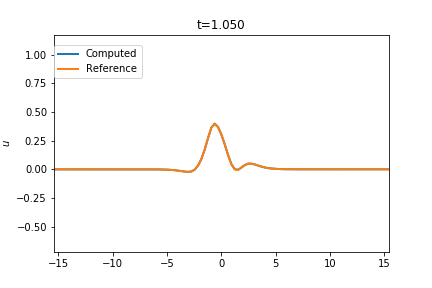
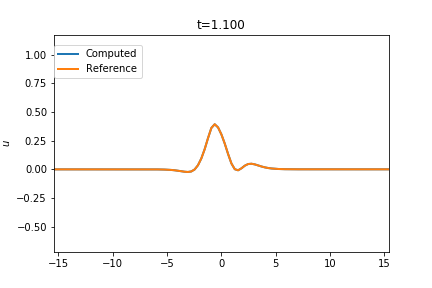
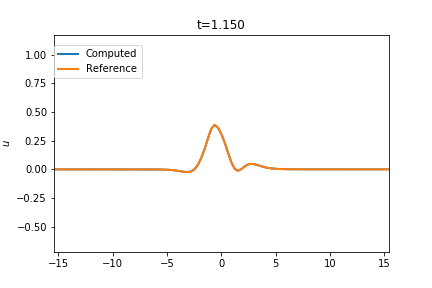
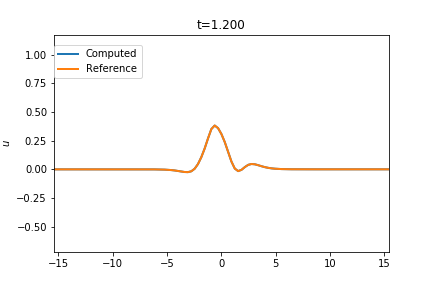
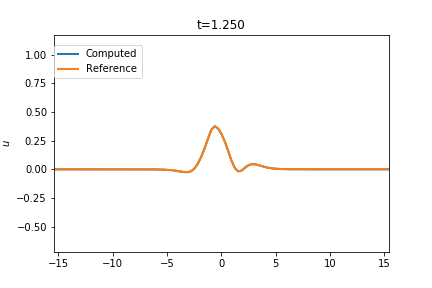
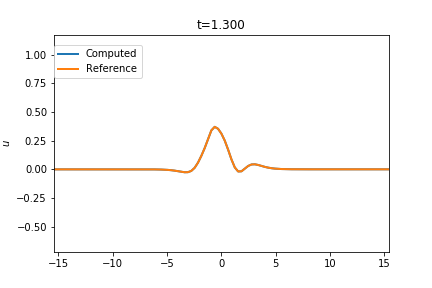
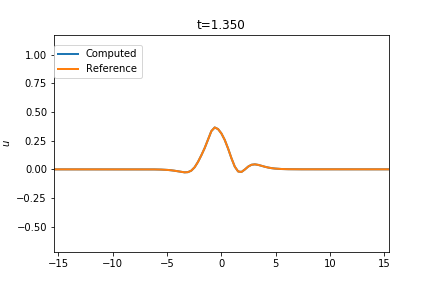
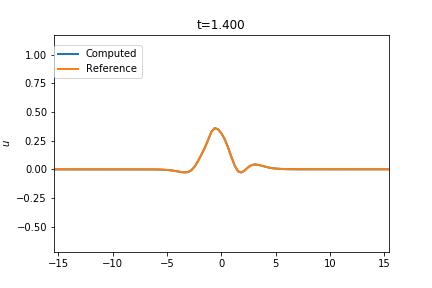
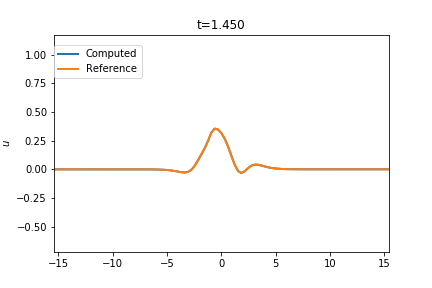
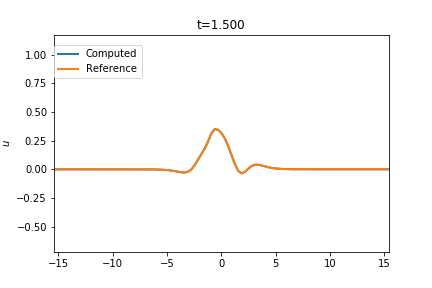
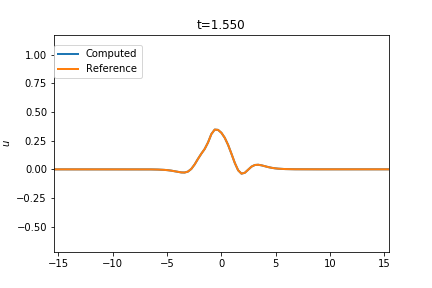
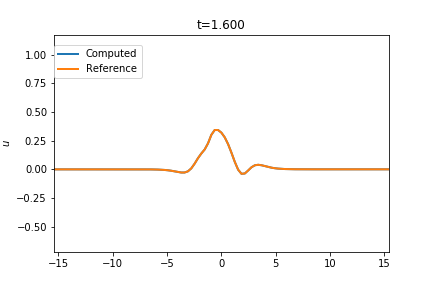
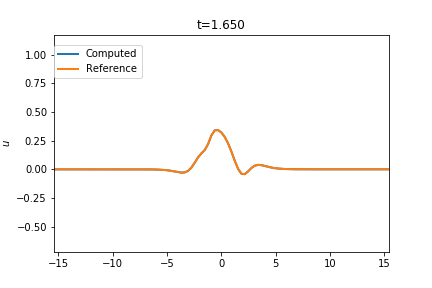
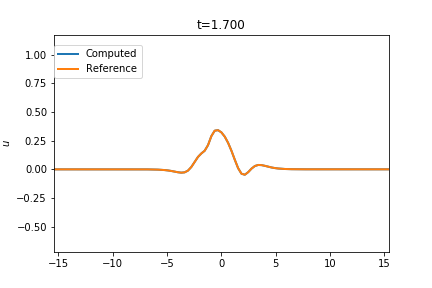
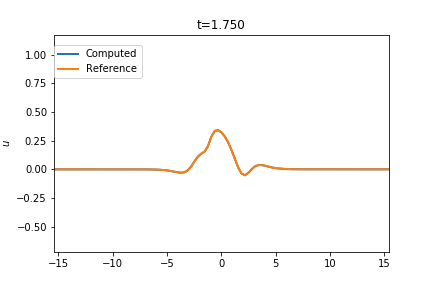
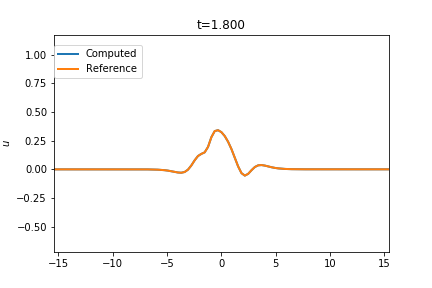
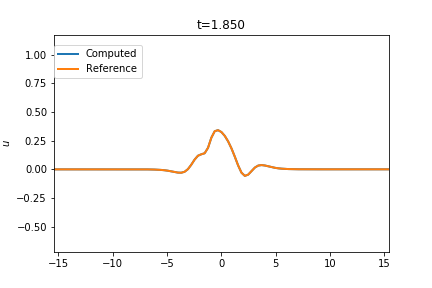
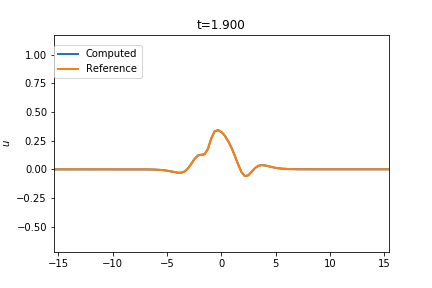
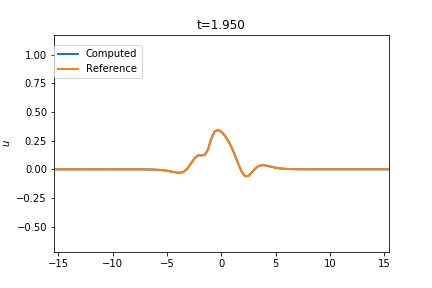
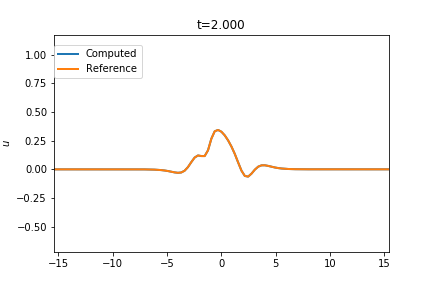
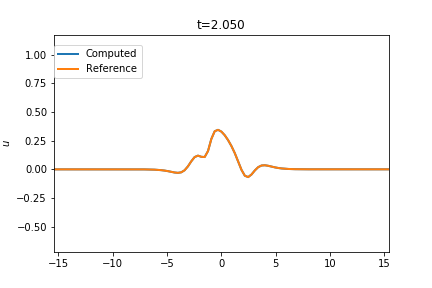
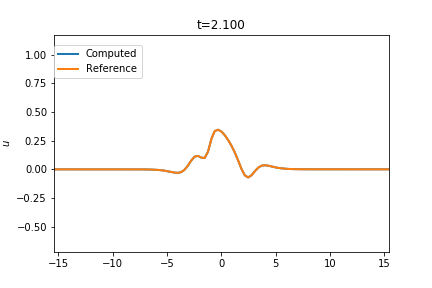
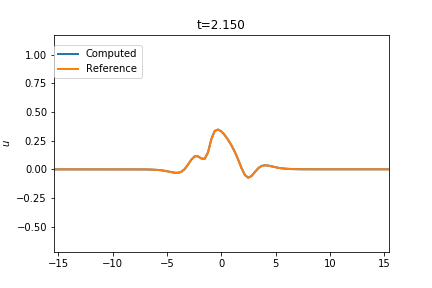
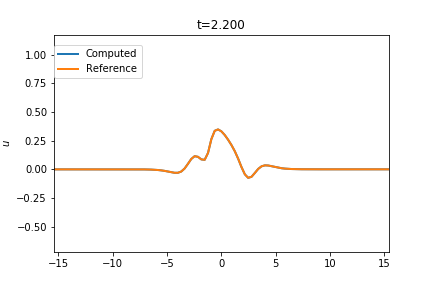
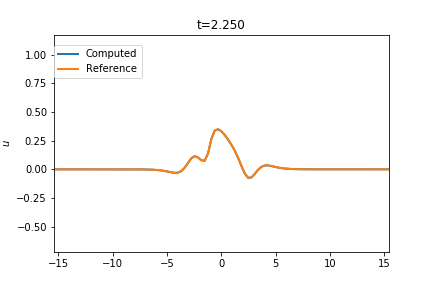
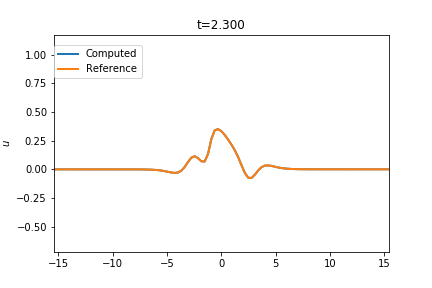
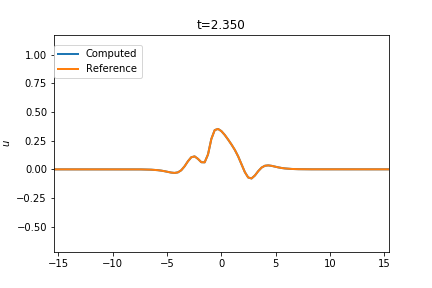
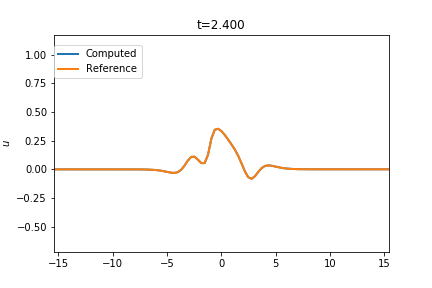
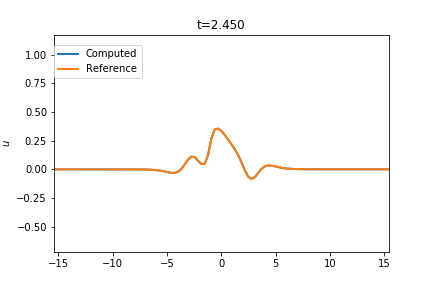
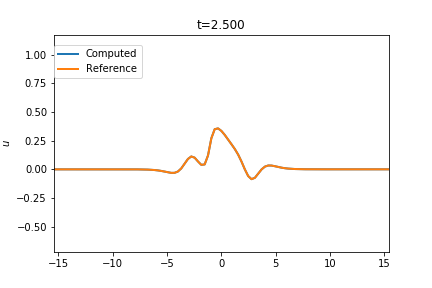
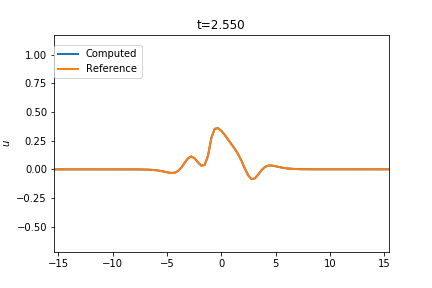
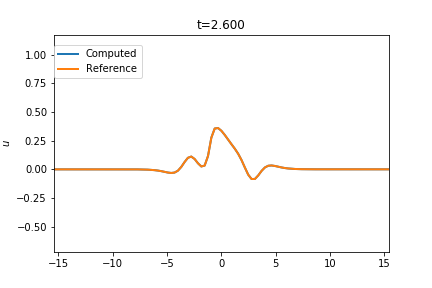
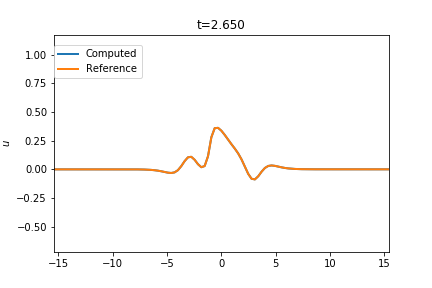
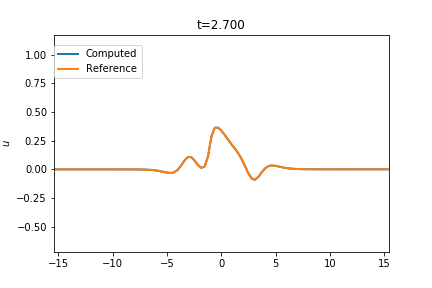
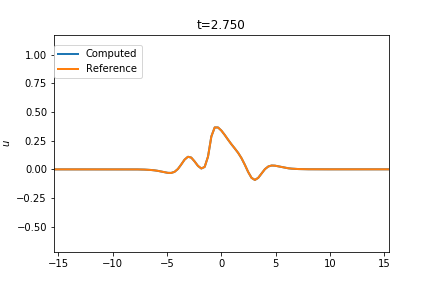
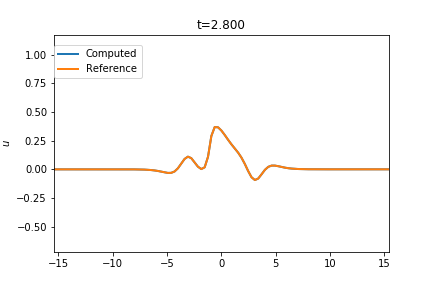
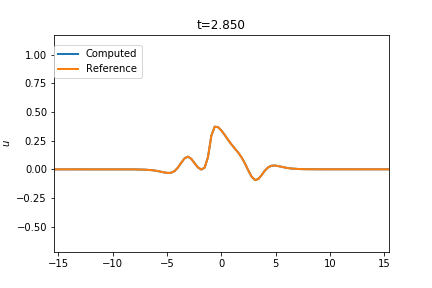
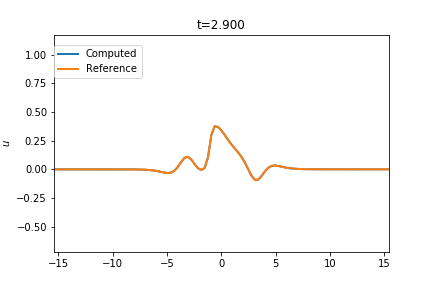
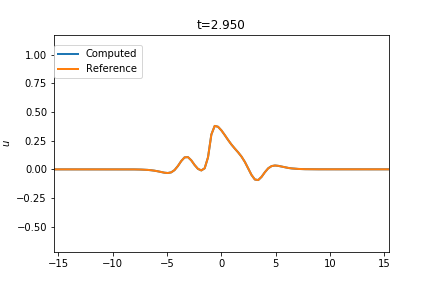
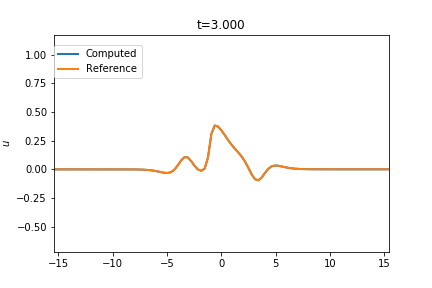
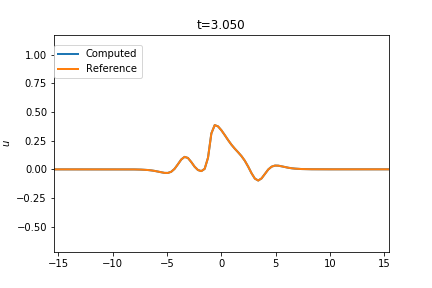
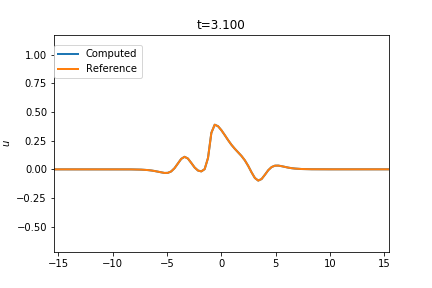
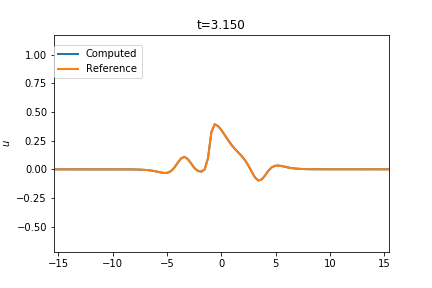
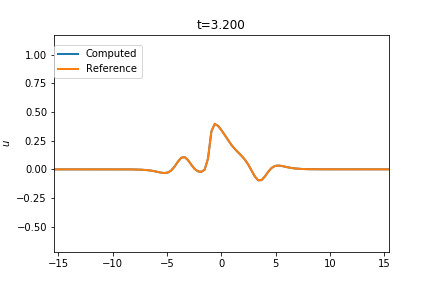
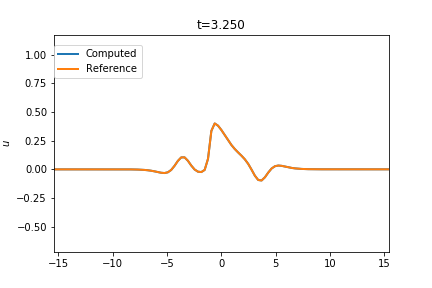
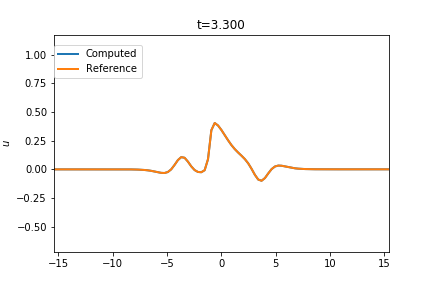
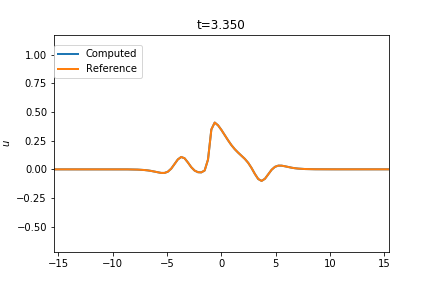
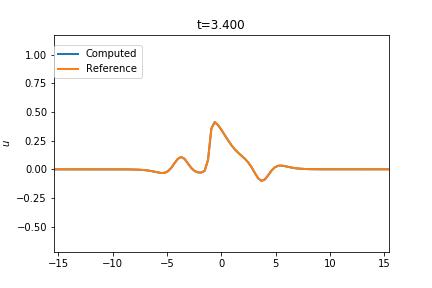
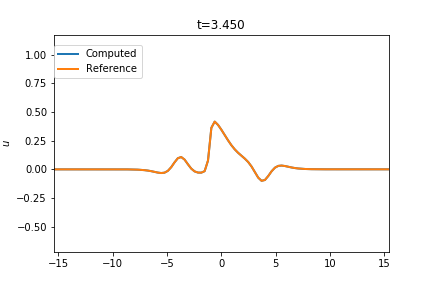
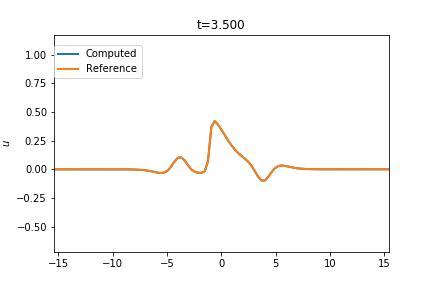
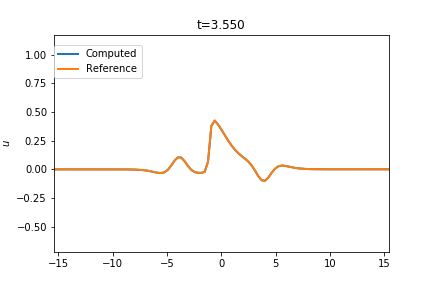
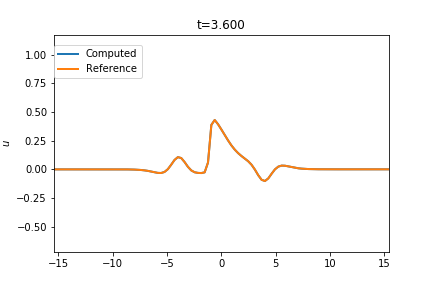
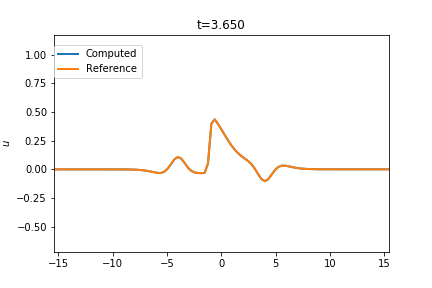
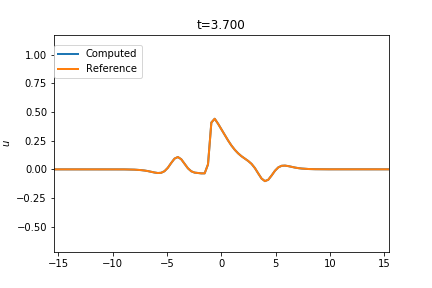
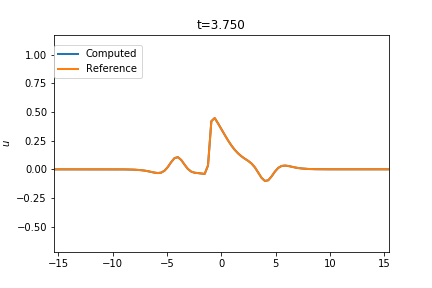
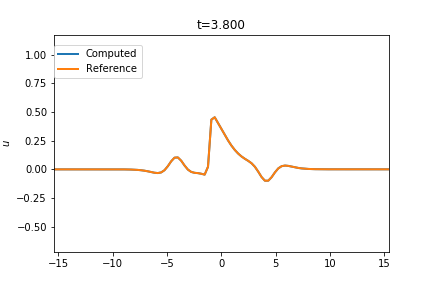
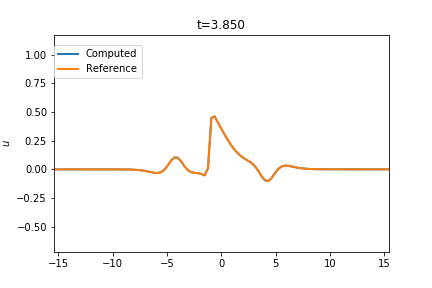
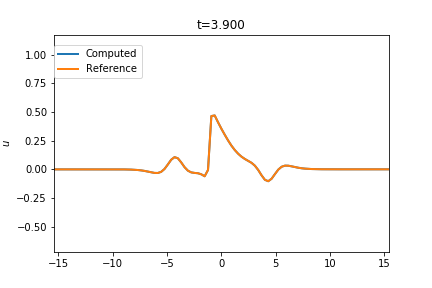
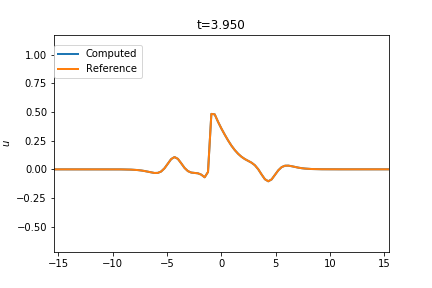
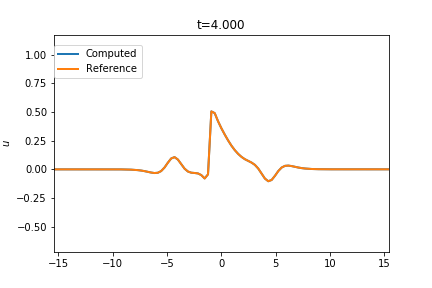
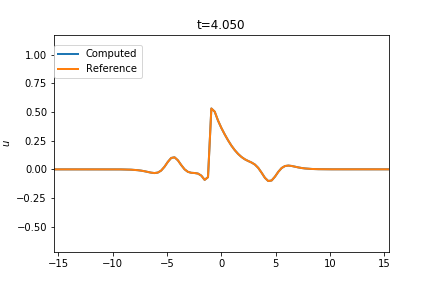
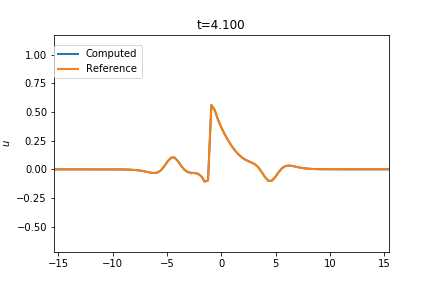
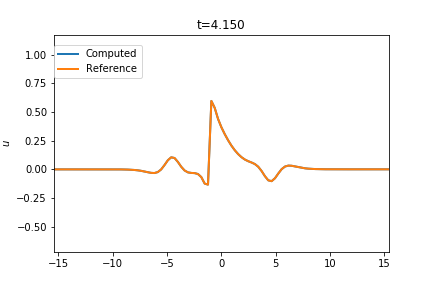
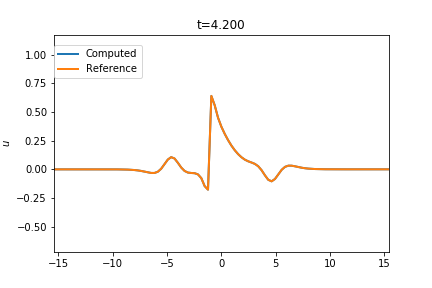
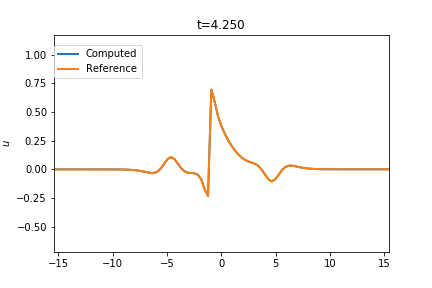
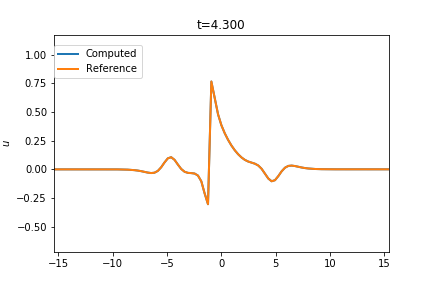
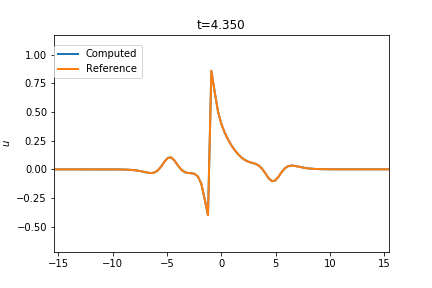
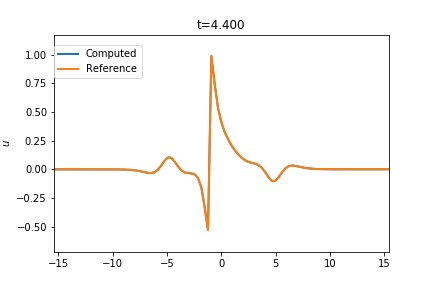
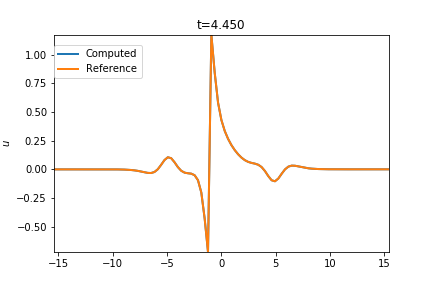

In [14]:
lb = ["Computed","Reference"]
# save = "./u_TBC_boussinesq.mp4"
save = None
gF.plotAnimationNSolutions(2,xref,np.array([uall1,uallref]),tall,xmin,xmax,umin,umax,lb,ylabel=r'$u$',location=(0.,0.8), savePath = save)